This notebook is a hands-on training that should help you get familiar with [Prophet](https://facebook.github.io/prophet/). Here are the topics we will be covering today:

- A short theorical introduction to understand how modelisation is split in different blocks
- Model tuning step-by-step
- Cross-validation
- Uncertainty on trend and seasonality
- Robustness to data quality (missing values and outliers)
- Parallelization

# 1. Set Up

## 1.1 Install and import all needed packages

Before starting, we need to install and import some libraries.

In [1]:
#!pip install pystan==2.19.1.1
#!pip install fbprophet==0.7.1
#!pip install cmdstanpy==1.0.8
#!pip install pmdarima==2.0.2

/bin/bash: pip: command not found


In [4]:
import fbprophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly, plot_yearly, plot_weekly, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics
from statsmodels.tsa.api import SimpleExpSmoothing
from pmdarima.arima import auto_arima

import pandas as pd
import numpy as np
from pathlib import Path
import os

import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import itertools
import time
import logging
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

logger = logging.getLogger('fbprophet')
logger.setLevel(logging.CRITICAL)
np.seterr(divide='ignore', invalid='ignore')

print(f'Prophet: {fbprophet.__version__}')
print(f'Numpy: {np.__version__}')
print(f'Pandas: {pd.__version__}')
print(f'Plotly: {plotly.__version__}')

Prophet: 0.7.1
Numpy: 1.21.5
Pandas: 1.4.4
Plotly: 5.9.0


In [3]:
notebook_path = Path(os.getcwd())
root_path = notebook_path.parent.absolute()
os.chdir(root_path)
str(root_path)

'/Users/Antoine/data_science_projects/natixis_challenge'

## 1.2 Access to Google Drive

After installing the packages, we'll need to link our Google Drive to our Colab notebook to import files that will be necessary in this hands-on. To do so, execute the cell below, and when prompted, go to the link provided by Google to log-in with your account.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Now your Google Drive is linked to Colab. Since you created a shortcut of the "Hands-on Prophet" folder shared earlier at the root of your Drive, you should be able to access it from this notebook. Make sure that the folder contains all the necessary files by running the command below.

In [ ]:
!ls drive/'MyDrive'/'3. Hands-on Prophet'

You should find:

*   The dataset we will use for the training : `dataset_m5.csv`
*   The file you copied this notebook from : `Hands-on Prophet - COPY THIS FILE.ipynb`
*   A notebook "solution" (ie without blank cells) you can use after the session : `Hands-on Prophet - SOLUTION.ipynb`
* A `Back-Up` folder



# 2. Some theory

Here is a quick introduction to understand basically how Prophet works. You can read the [paper](https://peerj.com/preprints/3190.pdf) to dive deeper into the details.

## 2.1 Prophet breaks down modelisation into 3 parts

**Prophet** decomposes the quantity to be forecasted as the **combination of 3 components**: trend, seasonality and events. Many parameters can be tuned to determine how each of these components will be fitted.

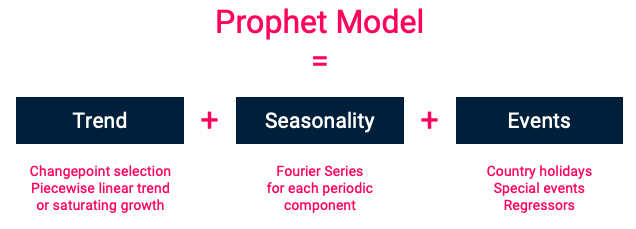



This formulation provides several advantages compared to traditional auto-regressive models such as ARIMA:
- **Flexibility**: All components can be adjusted and adapted to the problem at hand.
- **Robustness**: The measurements don't have to be regularly spaced (no need to interpolate missing values).
- **Speed**: Fitting is very fast, which makes it easy to explore many model specifications.
- **Interpretability**: The decomposition helps to understand how each component impacts the target.

All these sub-models are optimized with Bayesian methods (prior distributions are used to look for optimal parameters).

## 2.2 Trend model

Prophet can fit 3 distinct kinds of trend models: a saturating growth model, a piece-wise linear trend or a flat one. You have to select one of these options, depending on how the curve looks like.

**Option 1 : Saturating growth**

This option should be used if the curve is showing signs of future saturation, or if you know that it can't go over or below a given value (for example if predicting CPU usage). In that case, the trend will be estimated with a **logistic** curve. The difficult part is to choose the **saturation value** (cap or floor): talking with domain experts can be helpful to find the correct value.

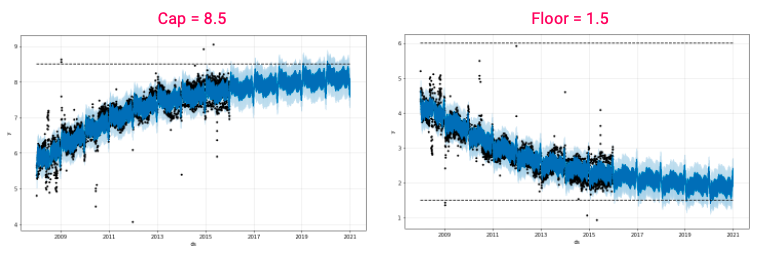

These cap and floor values can change over time or be set to a fixed value. From our experience, using a logistic growth can be make forecasts quite unstable, so it should be used only if there is a good reason for it.

**Option 2 : Piece-wise linear**

This is the default behaviour. The trend is piece-wise linear and the slope can change at different **changepoints**, which can either be manually specified (ex: when a product is launched), or automatically detected. Automatic changepoint detection works as described below:

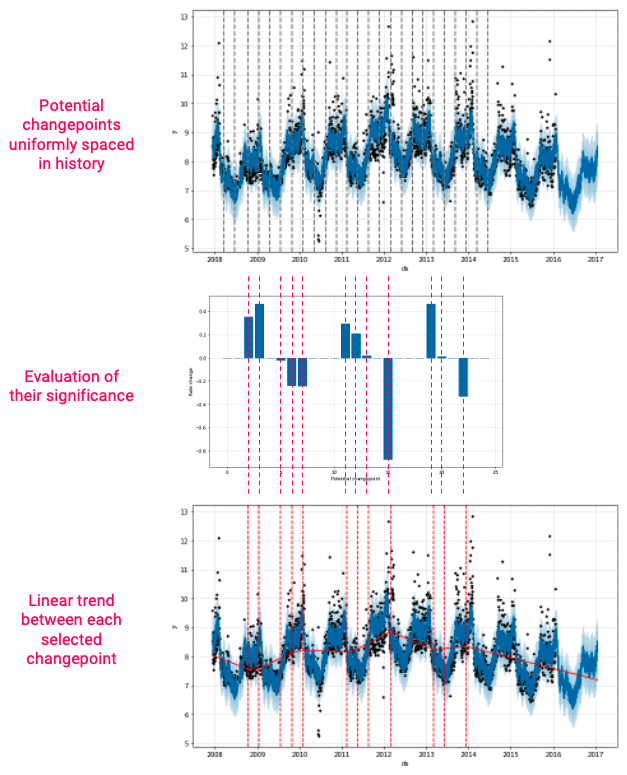


**Option 3 : Flat**

A flat trend can be set in case you want to ensure it remains constant over time (for example to visualize better the impact of other components).

## 2.3 Seasonality model

Most real time series have a **multi-period seasonality**. For example, sales in supermarkets often have patterns that repeat:
- Each week (affluence change on the week-ends)
- Each year (due to school breaks) 
- Or on some other business-related period (promotional calendar)

Prophet will fit a specific model for all these periodic effects. 

More precisely, each seasonality component will be approximated by a Fourier series.
Let $P$ be the regular period we expect the time series to have (ex:
`P = 365.25` for yearly cycles or `P = 7` for weekly cycles, with daily data). 
Then, the seasonal effect will be written:

$s(t)= \sum _{n=1}^{N}\left(a_{n}\cos \left({\tfrac {2\pi nt}{P}}\right)+b_{n}\sin \left({\tfrac {2\pi nt}{P}}\right)\right)$
  
During model fitting, Prophet estimates the coefficients `a_{n}` and `b_{n}` that works the best for training data.

The number `N` of components in the sum is the **Fourier oder**. It determines how smooth or complex the periodic component will be:
- A small value of N will fit a very smooth cycle, that might not catch seasonal patterns that change quickly.
- A high value of N will catch more complex patterns but increases the risk of overfitting.

## 2.4 Events model

**Holidays**

Special events and holidays can have important effects on the quantity to be forecasted. Here are a few things to know about how Prophet models these events :

- The impact of a given holiday is often similar year after year, therefore Prophet assigns each holiday a **unique value** accounting for the local change in the forecast on that particular day. Then, the same value will be applied to get the contribution of future holidays in forecasts.


- The effect is applied to the date on which the event was specified, and **only that particular date**. If you work at a weekly frequency  and have one data point every Sunday, an event that falls on a Monday will be ignored. To include it in the model, it should be moved to the date in the history dataframe for which the effect is desired, even if that's not the real date of the event.


- All holidays are considered **independent**, so each effect is calculated separately.


- It is often a good idea to compute impact for a **window of days around a particular holiday**, for example to model sales increasing in supermarkets before Christmas (and not only on D-day). In that case, each day in the window is flagged and treated by Prophet as a holidays itself.

**Regressors**

Continuous regressors can also be added. Like in a linear regression, Prophet will estimate a coefficient for each regressor which can be interpreted as the increase in prediction value for a unit increase in the regressor value. A regressor can either be:

- Values that are **known in the future at the same granularity** as the quantity to be forecasted.


- Or the **predicted values for another time series that is easier to forecast**. This approach could be used with hierarchical time series, by using a high level forecast to help the forecast of a lower level.

# 3. Practice

## 3.1 Loading data

We will work with data extracted from the M5 competition. It contains **daily sales** in several stores. There are also columns to flag some events and a column with the selling price, that can be used as a regressor.

In [6]:
df_all_stores = pd.read_csv("data/prophet_hands_on_dataset.csv")
df_all_stores.sort_values(['store_id', 'date']).head()

,date,store_id,sales,SuperBowl,Halloween,StPatricksDay,price
0,2011-01-29,CA_1,1267,0,0,0,4.0
10,2011-01-30,CA_1,1072,0,0,0,4.0
20,2011-01-31,CA_1,882,0,0,0,4.0
30,2011-02-01,CA_1,903,0,0,0,4.0
40,2011-02-02,CA_1,762,0,0,0,4.0


At first, we will only select sales from one store, as Prophet only forecasts one time series at a time.

In [7]:
store = 'CA_1'
df = df_all_stores.loc[df_all_stores['store_id'] == store].drop('store_id', axis=1)

## 3.2 Pre-processing

Very few pre-processing needs to be done to train a Prophet model:
- Date column has to be named **ds** and should be converted to datetime.
- Target column has to be named **y**.

In [8]:
df = df.rename(columns={'date': 'ds', 'sales':'y'})
df['ds'] = pd.to_datetime(df['ds'])

Let's split the data: training will be done on 2011-2014 and evaluation on 2015-2016.

In [9]:
split_date = '2015-01-01'
train, valid = df.loc[df['ds'] < split_date], df.loc[df['ds'] >= split_date]

fig = go.Figure()
fig.add_trace(go.Scatter(x=train["ds"], y=train["y"], mode="lines", name='Training', line=dict(color='#002244')))
fig.add_trace(go.Scatter(x=valid["ds"], y=valid["y"], mode="lines", name='Validation', line=dict(color='#ff0066')))
fig.update_layout(yaxis_title='Sales')
fig.show()

## 3.3 Useful functions

We will use the following functions to make the comparison of experiments throughout the training easier.

In [10]:
def forecast(model, train=train, valid=valid):
    """Fits a Prophet model to training data and makes forecasts on validation data.

    Parameters
    ----------
    model : Prophet
        Prophet model instantiated with the desired set of parameters.
    train : pd.DataFrame
        Training data, containing at least a date column (ds) and a target column (y).
    valid : pd.DataFrame
        Validation data, containing at least a date column (ds) and a target column (y).

    Returns
    -------
    pd.DataFrame
        Dataframe containing forecasts and ground truth on both training and validation data.
    """
    model.fit(train)
    full_df = pd.concat([train, valid], axis=0)
    pred = model.predict(full_df)
    pred['y'] = np.array(full_df['y'])
    return pred

In [11]:
def evaluate(pred, valid=valid):
    """Evaluates the performance of Prophet forecasts on validation data.

    Parameters
    ----------
    pred : pd.DataFrame
        Dataframe containing forecasts and ground truth on both training and validation data.
    valid : pd.DataFrame
        Validation data, containing at least a date column (ds) and a target column (y).

    Returns
    -------
    dict
        Performance on validation data (RMSE and MAPE).
    """
    y_pred, y_true = np.array(pred[-len(valid):].yhat), np.array(pred[-len(valid):].y)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true - y_pred) / y_true)[mask])
    rmse = np.sqrt(((y_true - y_pred) ** 2)[mask].mean())
    return {'RMSE': rmse, 'MAPE': mape}

In [12]:
def grid_search(grid):
    """Performs a grid search and shows the performance associated with all parameter combinations in the grid.

    Parameters
    ----------
    grid : dict
        Dictionary where keys are parameters names and values are lists of param values to be tested.
    """
    RMSEs = []
    combinations = [dict(zip(grid.keys(), i)) for i in itertools.product(*grid.values())]
    eval_df = pd.DataFrame(combinations)
    for params in tqdm(combinations):
        model = Prophet(**params)
        pred = forecast(model)
        RMSEs.append(evaluate(pred)['RMSE'])
    eval_df['RMSE'] = RMSEs
    plot_grid_search(eval_df, grid)

In [13]:
def plot_grid_search(eval_df, grid):
    """Plots performance on a bar plot for a 1D grid, on a heatmap for a 2D grid, or in a table otherwise.
    
    Parameters
    ----------
    eval_df : pd.DataFrame
        Dataframe showing RMSE on validation data for each combination of parameters tested.
    grid : dict
        Dictionary where keys are parameters names and values are lists of param values to be tested.
    """
    if len(grid.keys()) == 1:
        fig = px.bar(eval_df, x=list(grid.keys())[0], y='RMSE')
        fig.update_xaxes(type='category')
        fig.show()
    elif len(grid.keys()) == 2:
        data = eval_df.pivot_table(index=list(grid.keys())[0], columns=list(grid.keys())[1], values='RMSE')
        plt.figure(figsize=(7, 6))
        sns.heatmap(data, cmap='RdBu_r', annot=True, fmt=".1f")
        plt.title('RMSE')
        plt.show()
    else:
        print(eval_df)

## 3.4 Baseline

Let's train a few baseline models to get an idea of the level of performance we should achieve.

**ARIMA** (see [documentation](https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html) and [tutorial](https://towardsdatascience.com/time-series-forecasting-using-auto-arima-in-python-bb83e49210cd))

In [26]:
model = auto_arima(train[['ds','y']].set_index('ds'),
                   suppres_warnings=True, trace=True, random_state=20)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=5.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20081.754, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20064.254, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20049.818, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20079.755, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=19541.895, Time=1.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=19506.397, Time=2.93 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=19462.106, Time=7.05 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=19465.542, Time=3.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=18720.533, Time=9.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=18699.106, Time=6.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=19067.796, Time=3.42 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=18631.540, Time=3.93 sec
 ARIMA(4,1,2)(0,0,0)[0] interce

In [32]:
pred = pd.DataFrame({'y': valid.set_index(valid.ds, drop=True)['y'], 'yhat': model.predict(n_periods=len(valid))}, index=valid.ds)
print(evaluate(pred))
pred.head()

{'RMSE': 308.8540158572848, 'MAPE': 0.15150369459738788}


,y,yhat
ds,,
2015-01-01,1055,865.404150
2015-01-02,1490,975.779040
2015-01-03,1620,1424.611372
2015-01-04,1625,1597.774648
2015-01-05,1410,1415.622614


**Exponential smoothing** (see [documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html))

In [33]:
model = SimpleExpSmoothing(np.asarray(train[['y']]).ravel()).fit()
pred = pd.DataFrame({'y': valid['y'], 'yhat': model.forecast((len(valid)))})
evaluate(pred)

{'RMSE': 311.0252862739436, 'MAPE': 0.15867803108785264}

**Prophet with default parameters**

In [41]:
valid[["ds"]].head(2)

,ds
14330,2015-01-01
14340,2015-01-02


In [42]:
model = Prophet()
model.fit(train)
pred = model.predict(valid[["ds"]])
pred.head()

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -18.5488
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3022.72   0.000103248       86.8456      0.8524      0.8524      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3022.82   0.000216846       101.057   1.719e-06       0.001      175  LS failed, Hessian reset 
     160       3023.79   0.000208398       104.662   1.672e-06       0.001      286  LS failed, Hessian reset 
     199       3024.53   2.20938e-05       73.9575       0.435       0.435      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       3024.57   6.06215e-05       79.9534   8.117e-07       0.001      455  LS failed, Hessian reset 
     280       3024.58   1.90172e-07       62.7893      0.3997      0.3997      518   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,1373.093126,905.382927,1300.283322,1373.093126,1373.093126,-264.942673,-264.942673,-264.942673,-198.518290,-198.518290,-198.518290,-66.424384,-66.424384,-66.424384,0.0,0.0,0.0,1108.150453
1,2015-01-02,1373.147019,1124.570735,1521.863237,1373.147019,1373.147019,-51.386409,-51.386409,-51.386409,14.939216,14.939216,14.939216,-66.325625,-66.325625,-66.325625,0.0,0.0,0.0,1321.760609
2,2015-01-03,1373.200911,1422.782003,1814.406535,1373.200911,1373.200911,253.899895,253.899895,253.899895,319.897010,319.897010,319.897010,-65.997115,-65.997115,-65.997115,0.0,0.0,0.0,1627.100806
3,2015-01-04,1373.254804,1438.651061,1830.298531,1373.254804,1373.254804,260.855490,260.855490,260.855490,326.298711,326.298711,326.298711,-65.443221,-65.443221,-65.443221,0.0,0.0,0.0,1634.110294
4,2015-01-05,1373.308696,1067.959094,1446.363105,1373.308696,1373.308696,-119.146607,-119.146607,-119.146607,-54.471972,-54.471972,-54.471972,-64.674634,-64.674634,-64.674634,0.0,0.0,0.0,1254.162089


In [43]:
evaluate(pred[["ds"], ])

AttributeError: 'DataFrame' object has no attribute 'y'

In [44]:
model = Prophet()
pred = forecast(model)
print(pred.head(2))
evaluate(pred)

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -18.5488
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3022.72   0.000103248       86.8456      0.8524      0.8524      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3022.82   0.000216846       101.057   1.719e-06       0.001      175  LS failed, Hessian reset 
     160       3023.79   0.000208398       104.662   1.672e-06       0.001      286  LS failed, Hessian reset 
     199       3024.53   2.20938e-05       73.9575       0.435       0.435      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       3024.57   6.06215e-05       79.9534   8.117e-07       0.001      455  LS failed, Hessian reset 
     280       3024.58   1.90172e-07       62.7893      0.3997      0.3997      518   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



          ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2011-01-29  914.480157   994.933513  1377.600508   914.480157   914.480157   
1 2011-01-30  914.587626  1004.983258  1400.745886   914.587626   914.587626   

   additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
0      281.095291            281.095291            281.095291  319.897010   
1      288.143496            288.143496            288.143496  326.298711   

   weekly_lower  weekly_upper     yearly  yearly_lower  yearly_upper  \
0    319.897010    319.897010 -38.801719    -38.801719    -38.801719   
1    326.298711    326.298711 -38.155216    -38.155216    -38.155216   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   

   multiplicative_terms_upper         yhat     y  
0                         0.0  1195.575447  1267  
1                         0.0  1202.731122

{'RMSE': 149.87251265098843, 'MAPE': 0.08226476028942836}

In [35]:
pred.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y
0,2011-01-29,914.480157,1008.873865,1402.341858,914.480157,914.480157,281.095291,281.095291,281.095291,319.897010,319.897010,319.897010,-38.801719,-38.801719,-38.801719,0.0,0.0,0.0,1195.575447,1267
1,2011-01-30,914.587626,1005.897552,1383.429274,914.587626,914.587626,288.143496,288.143496,288.143496,326.298711,326.298711,326.298711,-38.155216,-38.155216,-38.155216,0.0,0.0,0.0,1202.731122,1072
2,2011-01-31,914.695096,626.022134,1022.250598,914.695096,914.695096,-91.899230,-91.899230,-91.899230,-54.471972,-54.471972,-54.471972,-37.427258,-37.427258,-37.427258,0.0,0.0,0.0,822.795866,882
3,2011-02-01,914.802566,501.822058,865.493140,914.802566,914.802566,-226.937952,-226.937952,-226.937952,-190.334788,-190.334788,-190.334788,-36.603164,-36.603164,-36.603164,0.0,0.0,0.0,687.864614,903
4,2011-02-02,914.910036,467.404167,854.873564,914.910036,914.910036,-253.482644,-253.482644,-253.482644,-217.809887,-217.809887,-217.809887,-35.672757,-35.672757,-35.672757,0.0,0.0,0.0,661.427392,762


When using models without any tuning, Prophet performs much better than ARIMA and Exponential Smoothing.

## 3.5 Model tuning

In this section, we will try to find the best parameters for our Prophet model on the dataset at hand, in order to achieve better results than the baseline. The best values will be stored in a dictionary named `params` to be able to reuse them easily afterwards.

In [ ]:
params = dict()

### 3.5.1 Trend parameters

#### Growth

The `growth` parameter allows you to choose between a saturating growth, a linear trend or a flat one. We have seen above that the curve grows regularly, so we will stick with the default growth value:

In [ ]:
params['growth'] = 'linear'

#### Changepoint prior scale

The `changepoint_prior_scale` is the most impactful parameter. It determines the flexibility of the trend, by affecting the number of changepoints detected and the magnitude of trend evolution at each changepoint. It should be tuned carefully:
- If it is too high, you can end up overfitting and including seasonality patterns in the trend, which is something to avoid.
- If it is too small, the model might not detect historical trend evoutions.

**Default value:** 0.05 (should be > 0)

Let's try several values to visualize the impact of the parameter. The built-in function `plot_plotly` shows several information:
* The blue line shows the **predictions** made by the model on both training and validation periods.
* The black points are the **actual values** of the target on training period.
* The red line is the **trend** estimated by the model, and the vertical lines are the **changepoints**.

In [ ]:
for i in [0.001, 0.1, 10]:
    params['changepoint_prior_scale'] = i
    model = Prophet(**params)
    pred = forecast(model)
    fig = plot_plotly(model, pred, changepoints=True, trend=True)
    fig.update_layout(title_text=f'changepoint_prior_scale = {i}', title_x=0.5)
    fig.show()

With a high `changepoint_prior_scale`, the model has more
flexibility in fitting the history, so training error should drop. However, when projected
forward this flexibility produces wide uncertainty intervals.

Let's select an intermediate value for now:

In [ ]:
params['changepoint_prior_scale'] = 0.5

#### Changepoint range

The `changepoint_range` determines the proportion of training data that will be used to detect changepoints.
By default, changepoints are only inferred from the first 80% traning data points in order to avoid overfitting fluctuations at the end of the time series. But you can increase this range if you consider that the last 20% contain significant information.

**Default value:** 0.8 (should be between 0 and 1)

Try several values to visualize the impact of the parameter:

In [ ]:
for i in [0.5, 0.75, 1]:
    params['changepoint_range'] = i
    model = Prophet(**params)
    pred = forecast(model)
    fig = plot_plotly(model, pred, changepoints=True, trend=True)
    fig.update_layout(title_text=f'changepoint_range = {i}', title_x=0.5)
    fig.show()

When changepoints are inferred from the whole training set (changepoint_range = 1), the future trend is decreasing abnormally. This is because the model has detected a huge drop in the last available data points (0 sales on 25/12/2014), and has not "seen" that sales have continued at a regular level in 2015.

#### Grid search for trend params

> *What combination of trend parameters achieves the best performance?*

Let's perform a grid search to find the combination of `changepoint_prior_scale` and `changepoint_range` parameters that provides the best performance on validation data.

In [ ]:
grid = {'changepoint_prior_scale': # List of values to test for changepoint_prior_scale ,
        'changepoint_range': # List of values to test for changepoint_range
        }
grid_search(grid)

We can now update the params dictionary with a good combination, and check that performance gets better:

In [ ]:
params['changepoint_prior_scale'] = # TBD
params['changepoint_range'] = # TBD

model = Prophet(**params)
pred = forecast(model)
evaluate(pred)

Here, the impact of tuning trend parameters is quite low, probably because default parameters are already good. This is not always the case, and detecting enough changepoints can be crucial in case some important changes occured during the training period (ex: covid).

### 3.5.2 Seasonality parameters

#### Select relevant seasonalities

By default, Prophet will fit weekly and yearly seasonalities, if the time series is more than two cycles long. It will also fit daily seasonality for a sub-daily time series. Let's see how the model performs with this default behavior. The built-in function `plot_components_plotly` shows the decomposition of the forecast into several components.

In [47]:
#model = Prophet(**params)
model = Prophet()

pred = forecast(model)
print(evaluate(pred))
plot_components_plotly(model, pred)

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Initial log joint probability = -18.5488
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3022.72   0.000103248       86.8456      0.8524      0.8524      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3022.82   0.000216846       101.057   1.719e-06       0.001      175  LS failed, Hessian reset 
     160       3023.79   0.000208398       104.662   1.672e-06       0.001      286  LS failed, Hessian reset 
     199       3024.53   2.20938e-05       73.9575       0.435       0.435      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       3024.57   6.06215e-05       79.9534   8.117e-07       0.001      455  LS failed, Hessian reset 
     280       3024.58   1.90172e-07       62.7893      0.3997      0.3997      518   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



{'RMSE': 149.87251265098843, 'MAPE': 0.08226476028942836}


/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/Users/Antoine/opt/anaconda3/lib/python3.9/site-packages/fbprophet/forecaster.py:891: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



The `add_seasonality` method allows you to have more control over seasonality and to add cycles that are not considered by default. For each seasonality added, you have to specify:
- A **name**: it will appear on the decomposition plot.
- The **period**: if it is set to 15 days, it tells the model that something that happens on a particular day is likely to happen again 15 days later.
- The **fourier_order**: you can start with an intermediary value like 10.
- Optionnaly a **prior_scale**, or you can keep the default value. 

The best way to know which seasonalities should be added for a specific use case is to talk with business.

> *What additional seasonalities can we include to improve performance?*

Classical seasonalities that are not added by default:
- Monthly (period = 30.5)
- Quarterly (period = 91.25)
- Any cycle that is relevant for the business

In [ ]:
model = Prophet(**params)
model.add_seasonality(period = # TBD (float) , 
                      name = # TBD (str), 
                      fourier_order = # TBD (int)
                      )
pred = forecast(model)
print(evaluate(pred))
plot_components_plotly(model, pred)

#### Fourier order

The `fourier_order` parameter determines the number of terms to include in the Fourier series that models a given cycle. Including more terms allows the model to catch seasonal patterns that change quickly, but it increases the risk of overfitting. Each seasonality has its own Fourier order. Default values are 3 for weekly seasonality and 10 for yearly seasonality.

Let's try different values for the yearly one and visualize the impact with the `plot_yearly` built-in function:

In [ ]:
for i in [3, 10, 50]:
    params['yearly_seasonality'] = i
    model = Prophet(**params)
    pred = forecast(model)
    plot_yearly(model, figsize=(16,4))
    plt.title(f'fourier_order = {i}')
    plt.show()

We can see that a high Fourier order makes the model learn very precise yearly variations. The objective is to find an order that catches accurate seasonal variations without modeling noise. Showing the curve to business stakeholders can help to find the right level. Let's keep the default value for now:

In [ ]:
params['yearly_seasonality'] = 10

#### Prior scale

The `seasonality_prior_scale` determines the magnitude of seasonality effects on predictions. Increasing this parameter will increase the number of sales forecasted attributed to seasonality, up to a certain limit.

**Default value:** 10 (should be > 0)

Let's see how it affects weekly seasonality, by using the `plot_weekly` built-in function:

In [ ]:
for i in [0.001, 0.01, 0.1]:
    model = Prophet(**params)
    model = model.add_seasonality(name='weekly', period=7, fourier_order=3, prior_scale=i)
    pred = forecast(model)
    plot_weekly(model, figsize=(16,4))
    plt.title(f'prior_scale = {i}')
    plt.show()

Here, it seems that increasing the prior scale boosts seasonality effects up to an amplitude of 300, with a value of 0.01.

#### Mode

The `seasonality_mode` parameter determines how the amplitude of the different seasonalities evolves over time:

- Use **additive** if this amplitude should remain constant over the whole period (ex: forecasting the number of people living in a small town, seasonal variations should remain the same year after year).


- Use **multiplicative** if seasonal variations should become higher when the trend grows (ex: forecasting the number of people living in a growing city).

When seasonality mode is multiplicative, holidays effects will also be modeled as multiplicative. Any added seasonalities or extra regressors will by default use the seasonality mode that has been selected, but can be overriden by specifying *mode='additive'* or *mode='multiplicative'* as an argument when adding the seasonality or regressor.

Let's stick with the default behavior here (additive), which works in most cases.

#### Grid search for seasonality params

> *What combination of seasonality parameters achieves the best performance?*
*Let's focus on yearly seasonality only.*

Let's perform a grid search to find the combination of `fourier_order` and `seasonality_prior_scale` yearly parameters that provides the best performance on validation data.

In [ ]:
grid = {'yearly_seasonality': # List of values to test for yearly_seasonality (Fourier order) ,
        'seasonality_prior_scale': # List of values to test for seasonality_prior_scale
        }
grid_search(grid)

Now we can update the params dictionary with a good combination and check performance:

In [ ]:
params['yearly_seasonality'] = # TBD (Fourier order)
params['seasonality_prior_scale'] = # TBD

model = Prophet(**params)
pred = forecast(model)
evaluate(pred)

We should then do the same for all selected seasonalities (monthly, weekly...).

### 3.5.3 Events, holidays, regressors and related parameters

We will use the following function to visualize the impact of external events or regressors on forecasts over time:

In [ ]:
def plot_separate_components(model, show_seasonalities_and_trends=False):
    """Plots forecasting components on separate subplots.

    Parameters
    ----------
    model : Prophet
        Prophet model instantiated with the desired set of parameters.
    show_seasonalities_and_trends : bool
        Whether or not to show seasonalities and trend in components plot.
    """
    
    # Train and forecast
    model = model.fit(train)  
    forecast = model.predict(pd.concat([train, valid], axis=0))
    
    # Evaluate model
    forecast['y'] = np.array(df['y'])
    print(evaluate(forecast))
    forecast = forecast.drop('y', axis=1)
    
    # Get forecast components
    components_col_names = [col.replace("_lower", "") for col in forecast.columns 
                            if "lower" in col and "yhat" not in col
                            and "additive" not in col and "multiplicative" not in col]
    if show_seasonalities_and_trends == False:
        components_col_names = [i for i in components_col_names 
                                if i not in ['trend', 'weekly', 'monthly', 'yearly']]
    components = forecast[components_col_names + ["ds"]].set_index("ds")
    
    # Plot forecast components
    features = components.columns
    n_features = len(components.columns)
    fig = make_subplots(rows=n_features, cols=1, subplot_titles=features)
    for i, col in enumerate(features):
        if col == "weekly":
            days = forecast["ds"].groupby(forecast.ds.dt.dayofweek).last()
            values = forecast.loc[forecast.ds.isin(days), ("ds", col)]
            values = values.iloc[values.ds.dt.dayofweek.values.argsort()]
            y = values[col]
            x = values.ds.dt.day_name()
        elif col == "monthly":
            days = forecast["ds"].groupby(forecast.ds.dt.day).last()
            values = forecast.loc[forecast.ds.isin(days), ("ds", col)]
            values = values.iloc[values.ds.dt.day.values.argsort()]
            y = values[col]
            x = values.ds.dt.day
        elif col == "yearly":
            year = forecast["ds"].max().year - 1
            days = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-31")
            y = forecast.loc[forecast["ds"].isin(days), col]
            x = days.dayofyear
        else:
            x = components.index
            y = components[col]
        fig.append_trace(go.Scatter(x=x, y=y, fill="tozeroy", name=col), row=i+1, col=1)
        fig.update_yaxes(title_text='Sales / Day', row=i+1, col=1)
    fig.update_layout(height=200 * n_features if n_features > 1 else 300)
    fig.show()

#### Holidays

Prophet can natively include holidays of most countries thanks to the `add_country_holidays` method. Let's visualize how these days impact forecasts:

In [ ]:
model = Prophet(**params)
model.add_country_holidays('US')
plot_separate_components(model)

If you suspect holidays effects to be overfitted or underfitted, you can adjust the `holidays_prior_scale` parameter to affect the magnitude of these impacts.

#### Events

The impact of a holiday before and after D-day is not taken into account with the `add_country_holidays` method. In case you want to model it, you should create a dataframe with past and future dates of the events to be modeled. The columns **lower_window** and **upper_window** specify the number of days that should be considered around the event.

In [ ]:
holidays = pd.DataFrame(columns=['holiday', 'ds', 'lower_window', 'upper_window'])
for event in ['SuperBowl', 'Halloween', 'StPatricksDay']:
    event_df = pd.DataFrame({'holiday': event,
                             'ds': df.loc[df[event] == 1]['ds'].values,
                             'lower_window': -5,
                             'upper_window': 2
                            })
    holidays = pd.concat([holidays, event_df], axis=0)

holidays

This dataframe just has to be set as the value for the `holidays` parameter to be included in the model.

In [ ]:
params['holidays'] = holidays
model = Prophet(**params)
plot_separate_components(model)

These specific events don't seem to improve performance. We can either try to tune `lower_window`, `upper_window` and `holidays_prior_scale` parameters, or just remove them.

> *Do you manage to reach a better performance with other `lower_window` and `upper_window` parameters ?*

In [ ]:
# TBD

#### Regressors

The `add_regressor` method allows you to include a continuous regressor such as the selling price. Let's see if this improves performance.

In [ ]:
model = Prophet(**params)
model.add_regressor('price', prior_scale=30)
plot_separate_components(model)

We should include the price regressor in our model if it has a significant impact on performance or if this impact really makes business sense. Here, the impact is quite low, the performance improvement could be some noise. Does the impact of price over time makes sense ? Let's plot price evolution between 2021 and 2016 to answer that question:



In [ ]:
fig = px.line(df, x='ds', y='price')
fig.show()

The price is increasing over time and we have seen just above that the impact of price on forecasts is increasing over time as well (it is negative in 2012 and positive in 2016). This means that Prophet thinks that sales are increasing with price, which is not intuitive. So we will exclude the price regressor from now.

### 3.5.4 Performance increment achieved with model tuning

Let's see how parameter tuning has improved performance compared to the baseline.

In [ ]:
model1 = Prophet()
model2 = Prophet(**params)
model2.add_country_holidays('US')

pred1, pred2 = forecast(model1), forecast(model2)
perf1, perf2 = evaluate(pred1), evaluate(pred2)
print(f"Baseline model performance : {perf1}")
print(f"Tuned model performance : {perf2}")

The RMSE has been lowered by approximately 10% thanks to parameters tuning. In our case, the most impactful elements to tune have been:

1.   Seasonality
2.   Events
3.   Trend

Therefore it could be better to tune parameters in that order on your projects, to achieve quick wins first. But keep in mind that the impact of tuning also depends on the dataset you are working on. Anyway, always **interact with business to understand whether performance improvements are significant or not**.

It could also be interesting to see how performance change from one day to another, especially around special days like holidays.

In [ ]:
def evaluate_daily(pred, valid=valid):
    """Returns daily absolute percetage error on validation data.
    
    Parameters
    ----------
    pred : pd.DataFrame
        Dataframe containing forecasts and ground truth on both training and validation data.
    valid : pd.DataFrame
        Validation data, containing at least a date column (ds) and a target column (y).

    Returns
    -------
    np.array
        Forecast accuracy for each day in validation set.
    np.array
        Days in validation set.
    """
    y_pred, y_true = np.array(pred[-len(valid):].yhat), np.array(pred[-len(valid):].y)
    mask = y_true != 0
    fa = 1 - np.abs((y_true - y_pred) / y_true)[mask]
    dates = valid[mask].ds
    return fa, dates

In [ ]:
perf1, dates = evaluate_daily(pred1)
perf2, _ = evaluate_daily(pred2)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dates, y=perf1, name='Baseline model', fill='tozeroy',
                         line=dict(color='#002244', width=1)))
fig.add_trace(go.Scatter(x=dates, y=perf2, name='Tuned model', 
                         fill='tonexty', 
                         line=dict(color='#ff0066', width=1)))
fig.update_yaxes(title='Forecast Accuracy', range=[0.5, 1.01])
fig.update_layout(
    xaxis=dict(rangeselector=dict(
        buttons=list([dict(count=1, label="1m", step="month", stepmode="backward"),
                      dict(count=6, label="6m", step="month", stepmode="backward"),
                      dict(count=1, label="YTD", step="year", stepmode="todate"),
                      dict(count=1, label="1y", step="year", stepmode="backward"),
                      dict(step="all")])),
        rangeslider=dict(visible=True),
        type="date"))
fig.show()

## 3.6 Local decomposition of forecasts

It is often useful to understand how the different model components have impacted a specific forecast, for explainability or debugging purposes. The following function can help to achieve that goal:

In [ ]:
def plot_local_decomposition(model, date):
    """Plots forecasting components for a specific date.
    
    Parameters
    ----------
    model : Prophet
        Prophet model instantiated with the desired set of parameters.
    date : str
        Date at format YYYY-MM-DD.
    """
    
    # Train and forecast
    model = model.fit(train)  
    forecast = model.predict(pd.concat([train, valid], axis=0))
    
    # Get local forecast components
    components_col_names = [col.replace("_lower", "") for col in forecast.columns 
                            if "lower" in col and "yhat" not in col
                            and "additive" not in col and "multiplicative" not in col
                            and "holidays" not in col]
    components = forecast[components_col_names + ["yhat", "ds"]].set_index("ds")
    waterfall = components.loc[pd.to_datetime(date)]
    waterfall = waterfall.loc[waterfall != 0]
    
    # Plot decomposition
    fig = go.Figure(
        go.Waterfall(
            orientation="v",
            measure=["relative"] * (len(waterfall) - 1) + ["total"],
            x=[x.capitalize() for x in list(waterfall.index)[:-1] + ["Forecast"]],
            y=list(waterfall.values),
            textposition="auto",
            text=["+" + str(round(x, 1)) if x > 0 else "" + str(round(x, 1)) 
                  for x in list(waterfall.values)[:-1]]
            + [str(round(waterfall.values[-1], 1))],
            decreasing={"marker": {"color": "#ff0066"}},
            increasing={"marker": {"color": "#002244"}},
            totals={"marker": {"color": "#66cccc"}},
        )
    )
    fig.update_yaxes(title_text=f'Forecasted sales for {date}')
    fig.show()

For example, let's see how the model is impacted by each component on November 27th 2014 (Thanksgiving):

In [ ]:
model = Prophet(**params)
model.add_country_holidays('US')
plot_local_decomposition(model, '2014-11-27')

## 3.7 Cross-validation

Prophet has an integrated cross-validation module that makes it easy to select model parameters robustly. Let's see how to use it.

### 3.7.1 Prophet built-in cross-validation functions

First, we need to instantiate the model and fit it on the whole dataset.

In [ ]:
model = Prophet(**params)
model.add_country_holidays('US')
model.fit(df)

Then, call the `cross_validation` built-in function to perform the cross-validation. The function takes 5 arguments:
- **model**: The model already fitted on the whole dataset.
- **initial**: The length of each folds' training period.
- **period**: The offset between all folds.
- **horizon**: The length of each folds' validation period.
- **parallel**: To enable parallel computation.


The following diagram shows how the dataset would be split for an initial value of 4 years, a period of 1 year and a horizon of 2 years:

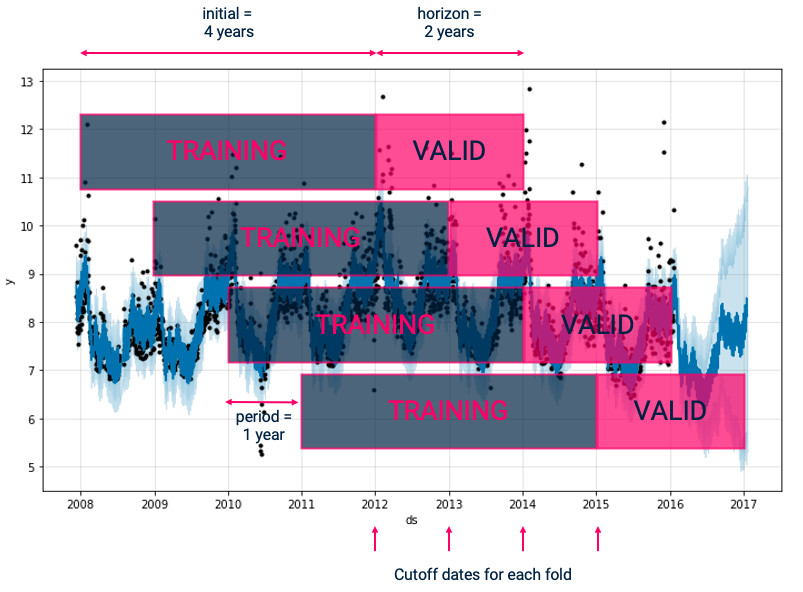

In [ ]:
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days', parallel='threads')
df_cv

The `performance_metrics` built-in function returns the average metrics over the validation periods of all folds, aggregated by horizon.

In [ ]:
performance_metrics(df_cv, rolling_window=0)

The `plot_cross_validation_metric` built-in function plots cross-validation results by horizon:
- Each point represents the performance on a specific cross-validation fold for a given forecasting horizon.
- The line shows the average results over all folds.

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

### 3.7.2 Grid search CV

We can now use these functions to tune parameters more robustly, with a cross-validated grid search. All combinations in the grid are tested and the one with the lowest RMSE over all CV folds is selected.

In [ ]:
def grid_search_cv(grid, initial, period, horizon, df=df):
    """Plots the cross-validated performance of Prophet models trained with parameters in the grid.

    Parameters
    ----------
    grid : dict
        Dictionary where keys are parameters names and values are lists of param values to be tested.
    initial : str
        Number of days in the training set of each fold.
    period : str
        Offset between each fold (in number of days).
    horizon : str
        Number of days in the validation set of each fold.
    df : pd.DataFrame
        Whole dataset.
    """
    RMSEs = []
    combinations = [dict(zip(grid.keys(), i)) for i in itertools.product(*grid.values())]
    eval_df = pd.DataFrame(combinations)
    for params in tqdm(combinations):
        model = Prophet(**params).fit(df)
        df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon, parallel="threads")
        df_p = performance_metrics(df_cv, rolling_window=1)
        RMSEs.append(df_p['rmse'].values[0])
    eval_df['RMSE'] = RMSEs
    plot_grid_search(eval_df, grid)

We will only try with a small grid here, to avoid a too long computation:

In [ ]:
grid = {'changepoint_prior_scale': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]}

initial = '730 days'
period = '180 days'
horizon = '180 days'
grid_search_cv(grid, initial, period, horizon)

## 3.8 Uncertainty

Prophet can provide uncertainty intervals in addition to the forecasts, which can be helpful to understand how confident the model is for a specific prediction. There are 3 sources of uncertainty: the **trend**, the **seasonality** and **noise**. The latter can't be computed, so we will focus on trend and seasonality.

### 3.8.1 Uncertainty in the trend

The first reason for uncertainty is the potential for future trend changes. Prophet has detected several changepoints in history, but we can't know for sure what will be the next ones. The most reasonable guess is to assume that the future will see similar trend changes as the history. More precisely, the model assumes that the **average frequency and magnitude of trend changes in the future will be the same as what has been observed before**. These trend changes are projected forward and uncertainty intervals are obtained by computing their distribution.

The consequence of this methodology is that a higher trend flexibility (ie a high `changepoint_prior_scale`) will increase uncertainty in the trend, because if we model more trend changes in history, then we will expect more in the future. Therefore, **uncertainty in the trend is a useful indicator for overfitting**: if the interval width increases abnormally in the future, the model is probably overfitting.

It is possible to affect the size of the interval thanks to the `interval_width` parameter. By default, an 80% uncertainty interval is computed. Let's see how the interval evolves when this parameter changes:

In [ ]:
for i in [0.5, 0.8, 0.95]:
    params['interval_width'] = i
    model = Prophet(**params)
    pred = forecast(model)
    fig = plot_plotly(model, pred, changepoints=True, trend=True)
    fig.update_layout(title_text=f'interval_width = {i}', title_x=0.5)
    fig.show()

### 3.8.2 Uncertainty in the seasonality

By default, Prophet only computes uncertainty in the trend. To get uncertainty in the seasonality, you have to specify the `mcmc_samples` parameter when instantiating the model. This uncertainty is computed through Monte-Carlo sampling and can take a very long time to compute. 

Here is what the output looks like:

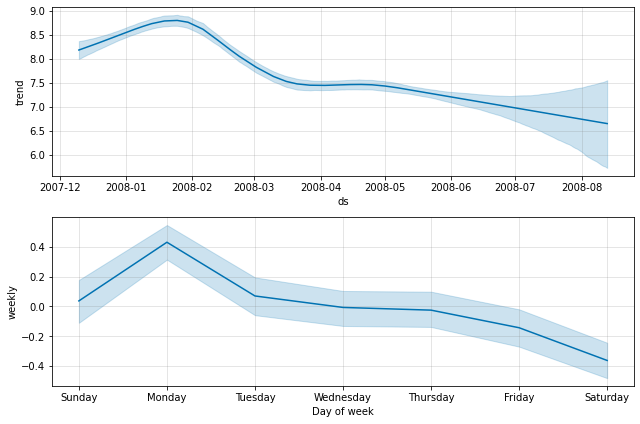

## 3.9 Robustness to data quality

Prophet can run even with noisy datasets. But it is important to understand how this noise affects performance.

### 3.9.1 Impact of missing values on performance

Let's replace the target with NaN for some fraction of training data, and see how Prophet deals with it.

In [ ]:
def add_missing_values(train, frac):
    """Replaces target by NaN values for a fraction of training data.

    Parameters
    ----------
    train : pd.DataFrame
        Training data, containing at least a date column (ds) and a target column (y).
    frac : float
        Proportion of missing values to include in training data (between 0 and 1).

    Returns
    ----------
    pd.DataFrame
        Training data with some missing values.
    """
    df = train.copy()
    df.loc[df.sample(frac=frac).index, 'y'] = np.nan
    return df

> *What fraction of missing values can Prophet manage without deteriorating performance?
Plot the RMSE on validation data depending on the fraction of missing values in training data.*

In [ ]:
# TBD

The model is very robust to missing data: only a high fraction of NaN values (> 80%) seems to significantly affect forecast performance.

### 3.9.2 Impact of outliers on performance

We can do the same experiment with outliers by:
- Multiplying the target by a coefficient (x0.33 or x3) for a fraction of training data to create "artificial outliers".
- Observing the impact on performance.

In [ ]:
def add_outliers(train, frac):
    """Replaces target by outlier values for a fraction of training data.
    
    Parameters
    ----------
    train : pd.DataFrame
        Training data, containing at least a date column (ds) and a target column (y).
    frac : float
        Proportion of outliers to include in training data (between 0 and 1).

    Returns
    ----------
    pd.DataFrame
        Training data with some outliers.
    """
    df = train.copy()
    df['coeff_outlier'] = np.random.choice([0.33, 3], size=len(train))
    df.loc[df.sample(frac=frac).index, 'y'] = df['y'] * df['coeff_outlier']
    return df

> *What fraction of outliers can Prophet manage without deteriorating performance?
Plot the RMSE on validation data depending on the fraction of outliers in training data.*

In [ ]:
# TBD

Even a small fraction of outliers affects the results significantly.

### 3.9.3 Outliers detection and removal

- As outliers impact model performance much more than missing values, it is safer to remove them from training data. 

- We can use uncertainty intervals to detect outliers and remove them: outliers are data points that fall outside the uncertainty interval.

The following functions can be used to implement this method:

In [ ]:
def detect_outliers(pred):
    """Flags forecasts that fall outside of uncertainty interval as outliers.

    Parameters
    ----------
    pred : pd.DataFrame
        Dataframe containing forecasts and ground truth on both training and validation data.

    Returns
    -------
    pd.DataFrame
        Prediction dataframe with a new boolean column named "outlier".
    """
    outliers = pred.copy()
    outliers['outlier'] = 0
    outliers.loc[outliers['y'] > outliers['yhat_upper'], 'outlier'] = 1
    outliers.loc[outliers['y'] < outliers['yhat_lower'], 'outlier'] = 1
    return outliers

def plot_outliers(interval_width):
    """Plots uncertainty interval and detected outliers.

    Parameters
    ----------
    interval_width : float
        Width of uncertainty interval (for trend uncertainty). Between 0 and 1.
    """
    model = Prophet(interval_width=interval_width)
    pred = forecast(model, add_outliers(train, 0.03))
    outliers = detect_outliers(pred).iloc[:730]
    fig = go.Figure()
    fig.add_trace(
            go.Scatter(
                x=outliers.loc[outliers['outlier'] == 1]["ds"],
                y=outliers.loc[outliers['outlier'] == 1]["y"],
                mode="markers",
                name='Outlier',
                marker=dict(color='#002244', size=5),
            )
        )
    fig.add_trace(
            go.Scatter(
                x=outliers["ds"],
                y=outliers["yhat_upper"],
                fill='tonexty',
                mode="lines",
                name='Upper bound',
                line=dict(color='#ff0066', width=0.5),
            )
        )
    fig.add_trace(
            go.Scatter(
                x=outliers["ds"],
                y=outliers["yhat_lower"],
                fill='tonexty',
                mode="lines",
                name='Lower bound',
                line=dict(color='#ff0066', width=0.5),
            )
        )
    fig.update_layout(showlegend=False, 
                      title=f'Outlier detection with {int(100*interval_width)}% uncertainty interval',
                      title_x=0.5, title_y=0.9)
    fig.show()

Before applying this method, we should choose the interval width such that the right amount of outliers is detected:

In [ ]:
for interval_width in [0.5, 0.75, 0.95]:
    plot_outliers(interval_width=interval_width)

Empirically, 75% seems to be a correct width for outliers detection. 

In [ ]:
INTERVAL_WIDTH = 0.75

Let's see how performance changes if outliers are removed from training data with this threshold:

In [ ]:
RMSEs = dict()
for frac_outliers in tqdm(range(0, 20, 2)):
    RMSEs[frac_outliers] = dict()
    
    # Train and forecast with outliers in training data
    model = Prophet(interval_width=INTERVAL_WIDTH)
    pred = forecast(model, add_outliers(train, frac_outliers/100))
    RMSEs[frac_outliers]['with_outliers'] = evaluate(pred)['RMSE']
    
    # Replace outliers with NaN values
    train_outliers = detect_outliers(pred).iloc[:len(train)]
    train_outliers.loc[train_outliers['outlier'] == 1, 'y'] = np.nan
    train_outliers = train_outliers[['ds', 'y']]
    
    # Train and forecast with missing values instead of outliers
    model = Prophet()
    pred = forecast(model, train=train_outliers)
    RMSEs[frac_outliers]['outliers_removed'] = evaluate(pred)['RMSE']
    

# Plot performance
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=list(RMSEs.keys()),
        y=[RMSEs[x]['with_outliers'] for x in RMSEs.keys()],
        name="With outliers",
        marker=dict(color='#ff0066'),
    )
)
fig.add_trace(
    go.Bar(
        x=list(RMSEs.keys()),
        y=[RMSEs[x]['outliers_removed'] for x in RMSEs.keys()],
        name="Outliers removed when detected",
        marker=dict(color='#002244'),
    )
)
fig.update_layout(
    barmode="overlay",
    title_text="Impact of outliers removal on performance",
    title_x=0.25,
    title_y=0.9,
    xaxis_title="% of outliers in training data",
    yaxis_title="RMSE on validation data",
)
fig.show()

### 3.9.4 Other methods for outlier detection

Other methods can be used to detect outliers:
- With [alibi-detect](https://docs.seldon.io/projects/alibi-detect/en/stable/examples/od_prophet_weather.html)
- With [ADTK](https://arundo-adtk.readthedocs-hosted.com/en/stable/notebooks/demo.html)

## 3.10 Parallelization of several models

Now let's see how to distribute the training of several Prophet models in a multiprocessed way. You can read [this notebook](https://aihub.cloud.google.com/u/0/p/75466a50-25d0-4d16-9071-dce56487515d) for more detailed information.

First, we need to create a list of tuples that contain input arguments for the `forecast` function for all 10 stores.

In [ ]:
def get_forecast_args(store):
    """Returns input arguments to call forecast function for a given store."""
    # Get training and validation dataframes at the right format
    df = df_all_stores.loc[df_all_stores['store_id'] == store].drop('store_id', axis=1)
    df = df.rename(columns={'date': 'ds', 'sales':'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    train, valid = df.loc[df['ds'] < split_date], df.loc[df['ds'] >= split_date]
    # Instantiate Prophet model with best params
    model = Prophet(**params)
    model.add_country_holidays('US')
    model.add_regressor('price', prior_scale=30)
    return model, train, valid

In [ ]:
forecast_args = [get_forecast_args(store) for store in sorted(df_all_stores['store_id'].unique())]

Then, processing is parallelized over all available CPU:

In [ ]:
ts = time.time()
with Pool(cpu_count()) as p:
    predictions = list(p.starmap(forecast, forecast_args))
te = time.time()
print(f"Time for training & forecast (using {cpu_count()} CPU): {round((te - ts), 1)} s")

We can then evaluate forecasts made for each store: 

In [ ]:
for i in range(df_all_stores['store_id'].nunique()):
    print(f"{sorted(df_all_stores['store_id'].unique())[i]} : {evaluate(predictions[i], forecast_args[i][2])}")

Similarly, we can perform a cross-validated grid search in a multiprocessed way.

> Find the best value for `changepoint_prior_scale` for each store, using the `grid_search_cv` function defined before (try only a few values to limit training time).

In [ ]:
def get_df_store(store):
    """Returns a dataframe with data of a given store."""
    df = df_all_stores.loc[df_all_stores['store_id'] == store].drop('store_id', axis=1)
    df = df.rename(columns={'date': 'ds', 'sales':'y'})
    df['ds'] = pd.to_datetime(df['ds'])
    return df

In [ ]:
# TBD